In [9]:
import zipfile
import os

def unzip_file(file_path, extract_to):
    """
    Unzips a single zip file to the specified directory.
    Args:
    - file_path (str): Path to the .zip file.
    - extract_to (str): Directory where the files will be extracted.
    """
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f'Extracted: {file_path} to {extract_to}')

# List of separate zip file paths
zip_files = [
    '/content/ASVspoof2017_V2_train.zip',
    '/content/ASVspoof2017_V2_eval.zip',
    '/content/ASVspoof2017_V2_dev.zip',
    '/content/protocol_V2.zip',
    # Add more zip file paths as needed
]

# Specify the directory to extract files to
extract_directory = '/'  # Replace with your directory path

# Unzip each file in the list
for zip_file in zip_files:
    unzip_file(zip_file, extract_directory)


Extracted: /content/ASVspoof2017_V2_train.zip to /
Extracted: /content/ASVspoof2017_V2_eval.zip to /
Extracted: /content/ASVspoof2017_V2_dev.zip to /
Extracted: /content/protocol_V2.zip to /


In [10]:
!pip install tensorflow librosa pandas numpy matplotlib scikit-learn


In [11]:
# STEP 1: INSTALLATIONS & IMPORTS
!pip install tensorflow librosa pandas numpy matplotlib scikit-learn tqdm
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, optimizers, callbacks


In [12]:
# STEP 2: DEFINE PATHS (MATCHING YOUR STRUCTURE)
base_dir = '.'  # Current directory where your folders are
paths = {
    'train': {
        'audio': os.path.join(base_dir, '/ASVspoof2017_V2_train'),
        'protocol': os.path.join(base_dir, '/protocol_V2', '/protocol_V2/ASVspoof2017_V2_train.trn.txt')
    },
    'dev': {
        'audio': os.path.join(base_dir, '/ASVspoof2017_V2_dev'),
        'protocol': os.path.join(base_dir, '/protocol_V2', '/protocol_V2/ASVspoof2017_V2_dev.trl.txt')
    },
    'eval': {
        'audio': os.path.join(base_dir, '/ASVspoof2017_V2_eval'),
        'protocol': os.path.join(base_dir, '/protocol_V2', '/protocol_V2/ASVspoof2017_V2_eval.trl.txt')
    }
}

In [13]:
# STEP 3: LOAD PROTOCOL FILES
def load_protocol(file_path):
    return pd.read_csv(file_path, sep=' ', header=None,
                     names=['file_id', 'label', 'speaker_id', 'phrase_id',
                            'env_id', 'playback_id', 'recording_id'])

print("Loading protocol files...")
train_protocol = load_protocol(paths['train']['protocol'])
dev_protocol = load_protocol(paths['dev']['protocol'])
eval_protocol = load_protocol(paths['eval']['protocol'])


Loading protocol files...


In [14]:
# STEP 4: FEATURE EXTRACTION
def extract_features(file_path, sr=16000, n_mels=64, duration=3):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        if len(y) < sr*duration:
            y = np.pad(y, (0, max(0, sr*duration - len(y))))

        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        log_mel = librosa.power_to_db(mel, ref=np.max)
        return (log_mel - log_mel.mean()) / (log_mel.std() + 1e-6)
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

In [15]:
# STEP 5: DATA PREPARATION
def prepare_data(protocol_df, audio_dir, set_type):
    features = []
    labels = []

    print(f"\nPreparing {set_type} set from {audio_dir}...")

    for idx, row in tqdm(protocol_df.iterrows(), total=len(protocol_df), desc=f"Processing {set_type}"):
        # File paths already have correct prefixes (T_, D_, E_)
        file_path = os.path.join(audio_dir, row['file_id'])

        feat = extract_features(file_path)
        if feat is not None:
            # Pad/truncate to fixed size (64x300)
            fixed_frames = 300
            if feat.shape[1] < fixed_frames:
                feat = np.pad(feat, ((0,0), (0,fixed_frames-feat.shape[1])), mode='constant')
            else:
                feat = feat[:, :fixed_frames]

            features.append(feat)
            labels.append(1 if row['label'] == 'spoof' else 0)

    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Add channel dimension
    features = np.expand_dims(features, -1)

    print(f"Successfully processed {len(features)}/{len(protocol_df)} files")
    print(f"Feature shape: {features.shape}")

    return features, labels


In [16]:
# STEP 6: PROCESS ALL DATASETS
print("\nProcessing datasets...")
X_train, y_train = prepare_data(train_protocol, paths['train']['audio'], "Train")
X_dev, y_dev = prepare_data(dev_protocol, paths['dev']['audio'], "Dev")
X_eval, y_eval = prepare_data(eval_protocol, paths['eval']['audio'], "Eval")




Processing datasets...

Preparing Train set from /ASVspoof2017_V2_train...


Processing Train: 100%|██████████| 3014/3014 [00:38<00:00, 78.70it/s]


Successfully processed 3014/3014 files
Feature shape: (3014, 64, 300, 1)

Preparing Dev set from /ASVspoof2017_V2_dev...


Processing Dev: 100%|██████████| 1710/1710 [00:09<00:00, 178.28it/s]


Successfully processed 1710/1710 files
Feature shape: (1710, 64, 300, 1)

Preparing Eval set from /ASVspoof2017_V2_eval...


Processing Eval: 100%|██████████| 13306/13306 [01:34<00:00, 140.42it/s]


Successfully processed 13306/13306 files
Feature shape: (13306, 64, 300, 1)


In [17]:
# STEP 7: BUILD MODEL
def build_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

input_shape = X_train.shape[1:]
model = build_model(input_shape)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 298, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 149, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 31, 149, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 147, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 73, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 71, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 35, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6, 35, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 26880)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,440,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,534,465 (13.48 MB)

 Trainable params: 3,534,017 (13.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
import torch

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [25]:
import tensorflow as tf

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 62, 298, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 62, 298, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 31, 149, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 31, 149, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 29, 147, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 29, 147, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 14, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 14, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,425 (91.50 KB)

 Trainable params: 23,233 (90.75 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.5168 - auc: 0.4894 - loss: 1.4221 - precision: 0.5134 - recall: 0.8840 - val_accuracy: 0.4444 - val_auc: 0.4800 - val_loss: 1.3112 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5347 - auc: 0.5640 - loss: 1.2866 - precision: 0.5316 - recall: 0.4728 - val_accuracy: 0.4444 - val_auc: 0.4598 - val_loss: 1.3048 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6165 - auc: 0.6648 - loss: 1.2260 - precision: 0.6047 - recall: 0.6825 - val_accuracy: 0.4444 - val_auc: 0.4973 - val_loss: 1.2904 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6264 - auc: 0.6812 - loss: 1.1934 - precision: 0.6181 - recall: 0.6135 - val_accuracy: 0.4444 - va

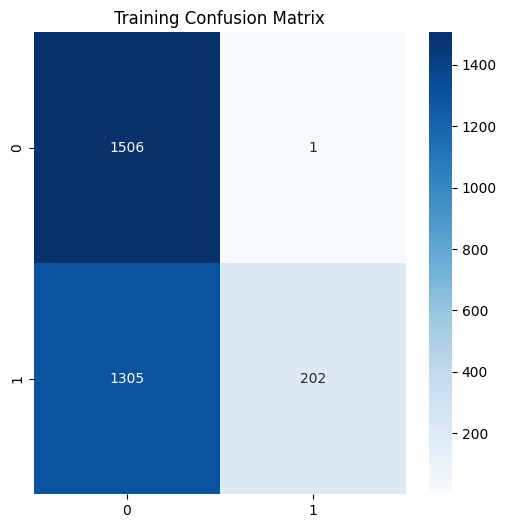

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Development Set Evaluation:
              precision    recall  f1-score   support

        real       0.46      1.00      0.63       760
       spoof       1.00      0.07      0.12       950

    accuracy                           0.48      1710
   macro avg       0.73      0.53      0.38      1710
weighted avg       0.76      0.48      0.35      1710

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Equal Error Rate (EER): 0.2474


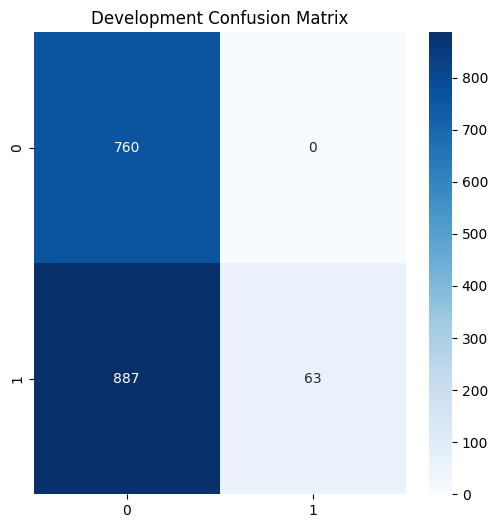

416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Evaluation Set Evaluation:
              precision    recall  f1-score   support

        real       0.10      1.00      0.18      1298
       spoof       1.00      0.03      0.06     12008

    accuracy                           0.12     13306
   macro avg       0.55      0.51      0.12     13306
weighted avg       0.91      0.12      0.07     13306

416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Equal Error Rate (EER): 0.2591


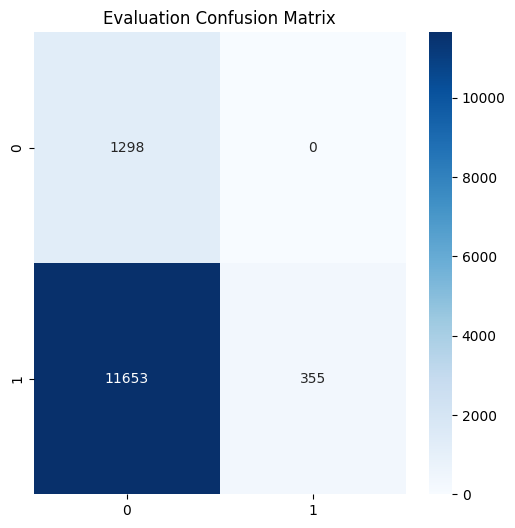

In [37]:
# STEP 1: CLASS BALANCE CORRECTION
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import callbacks  # Import callbacks separately

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# STEP 2: ENHANCED MODEL ARCHITECTURE
def build_balanced_model(input_shape):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),

        # First Conv Block
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.5),

        # Second Conv Block
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.5),

        # Global Pooling instead of Flatten
        tf.keras.layers.GlobalAveragePooling2D(),

        # Classifier
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

# STEP 3: IMPROVED TRAINING
balanced_model = build_balanced_model(X_train.shape[1:])
balanced_model.summary()

# Enhanced callbacks - FIXED IMPLEMENTATION
training_callbacks = [
    tf.keras.callbacks.EarlyStopping(  # Use tf.keras.callbacks directly
        monitor='val_auc',
        patience=15,
        mode='max',
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=5,
        mode='max'
    )
]

# Train with class weights
history = balanced_model.fit(
    X_train, y_train,
    validation_data=(X_dev, y_dev),
    class_weight=class_weights,
    epochs=100,
    batch_size=64,
    callbacks=training_callbacks  # Use the corrected callbacks list
)

# STEP 4: EVALUATION METRICS
def enhanced_evaluation(model, X, y, set_name):
    y_pred = (model.predict(X) > 0.5).astype(int)
    print(f"\n{set_name} Set Evaluation:")
    print(classification_report(y, y_pred, target_names=['real', 'spoof']))

    # Calculate EER
    from scipy.optimize import brentq
    from scipy.interpolate import interp1d
    from sklearn.metrics import roc_curve

    fpr, tpr, thresholds = roc_curve(y, model.predict(X).ravel())
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    print(f"Equal Error Rate (EER): {eer:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{set_name} Confusion Matrix')
    plt.show()

# Evaluate all sets
enhanced_evaluation(balanced_model, X_train, y_train, "Training")
enhanced_evaluation(balanced_model, X_dev, y_dev, "Development")
enhanced_evaluation(balanced_model, X_eval, y_eval, "Evaluation")

In [38]:
# STEP 9: EVALUATE
def evaluate_model(model, X, y, set_name):
    y_pred = (model.predict(X) > 0.5).astype(int)
    print(f"\n{set_name} Set Evaluation:")
    print(classification_report(y, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

evaluate_model(model, X_train, y_train, "Training")
evaluate_model(model, X_dev, y_dev, "Development")
evaluate_model(model, X_eval, y_eval, "Evaluation")


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Training Set Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1507
           1       0.50      1.00      0.67      1507

    accuracy                           0.50      3014
   macro avg       0.25      0.50      0.33      3014
weighted avg       0.25      0.50      0.33      3014

Confusion Matrix:
[[   0 1507]
 [   0 1507]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Development Set Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       760
           1       0.56      1.00      0.71       950

    accuracy                           0.56      1710
   macro avg       0.28      0.50      0.36      1710
weighted avg       0.31      0.56      0.40      1710

Confusion Matrix:
[[  0 760]
 [  0 950]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Evaluation Set Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1298
           1       0.90      1.00      0.95     12008

    accuracy                           0.90     13306
   macro avg       0.45      0.50      0.47     13306
weighted avg       0.81      0.90      0.86     13306

Confusion Matrix:
[[    0  1298]
 [    0 12008]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# STEP 10: SAVE MODEL
model.save('asvspoof_detection_model.h5')
print("\nModel saved as 'asvspoof_detection_model.h5'")


Model saved as 'asvspoof_detection_model.h5'
